# Analysis of Image to Image GANs

## Methods For Analysis

The following code blocks import all neccessary libararies and classes for analyzing these Image To Image GANs. Currently the metrics for evaluation are:
* Frechet Inception Distance

Each analysis class has \__str__ and analyze methods that allow the output of the models to be analyzed without being dependent on knowing what the metric itself is. 

In [1]:
from utils import *
from fid import FID
fid = FID()

/fs/junkfood/ssaxena1/miniconda3/envs/gan/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
real_path = "Pix2Pix/figures/facades_old/202/training/full"
gen_path = "Pix2Pix/figures/facades_old/202/training/gen"
i, j = get_images(real_path, gen_path)
print(fid.__str__(), fid.find_fid(i, j))

FID 304.8691472840694


## Training and Analyzing Pix2Pix

The current environment is set to run with Tensorflow, but this can be changed by modifying the backend to theano and changing the image_data_format to channels_first. The dataset can also be modified to be something other than the facades dataset. 

### Set Training Parameters

The code below trains and analyzes the Pix2Pix model on a given dataset. 

You can provide your own arguments to train this model by altering the d_params dictionary. These are the arguments I have set in the code block below:

* dset - Location of the dataset within the logging directory
* batch_size - Size of batch for training
* n_batch_per_epoch - Number of batches in one epoch
* model_name - Name/Location of the model within the logging directory
* epoch - Number of epochs in one saving/analyzing iteration
* do_plot - Prints model summary and plots model architecture
* image_data_format - channels_last for tensorflow backend and channels_first for theano backend
* img_dim - Dimension of the Square Image
* patch_size - Patch Size for the discriminator
* logging_dir - The directory where everything is stored (models, logs, data, figures)
* save_latest - Saves only the latest model (space efficient)
* load_model - Location of saved models or None
* load_epoch - Epoch of saved models or latest or None
* base_epoch - Base epoch for all stats and graphs (default is 0)

To analyze this model while its training, add the following arguments to d_params

* analyze - method of analysis
* analyze_batch - batch of images to analyze
* load_analysis - Load Old Analysis (Useful when training saved models)

The code below is configured to save models in "logging_dir/models/model_name/", save figures in "logging_dir/figures/model_name/", load data from "logging_dir/data/dset/processed/", and save analysis in "logging_dir/figures/model_name/" 

In [32]:
import os
import argparse
import sys

image_data_format = "channels_last"
logging_dir = "Pix2Pix"
model = "facades"
dset = model
analyze = fid

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras.backend as K
K.set_image_data_format(image_data_format)

sys.path.append("Pix2Pix/src/model/")
sys.path.append("Pix2Pix/src/utils/")

d_params = {"dset": dset,
            "generator": "upsampling",
            "batch_size": 4,
            "n_batch_per_epoch": 100,
            "nb_epoch": 400,
            "model_name": model,
            "epoch": 1,
            "nb_classes": 2,
            "do_plot": False,
            "image_data_format": image_data_format,
            "bn_mode": 2,
            "img_dim": 256,
            "use_label_smoothing": False,
            "label_flipping": 0,
            "patch_size": (64, 64),
            "use_mbd": False,
            "logging_dir": logging_dir,
            "save_latest": True,
            "load_model": model,
            "load_epoch": "latest",
            "base_epoch": 90,
            "load_analysis": "analysis.pkl",
            "analyze": analyze,
            "analyze_batch": 5
            }

In [ ]:
import train
import importlib
importlib.reload(train)

analysis = train.train(**d_params)

Start training
396/400 [============================>.] - ETA: 7s - D logloss: 0.8073 - G tot: 11.9610 - G L1: 1.1434 - G logloss: 0.5266 
Epoch 1/400, Time: 726.3739807605743
FID Analysis: Training - 442 Validation - 419
Time: 796.5368447303772
  4/400 [..............................] - ETA: 10:13 - D logloss: 0.6241 - G tot: 12.0963 - G L1: 1.1558 - G logloss: 0.5382

### Plotting Results of Live Analysis

This code block plots the analysis of a model either returned by train.train or found in an analysis pickle file. Currently two plots are included:

* Log Loss
    * Generator Loss
    * Discriminator Loss
* Frechet Inception Distance
    * Trainining FID
    * Validation FID

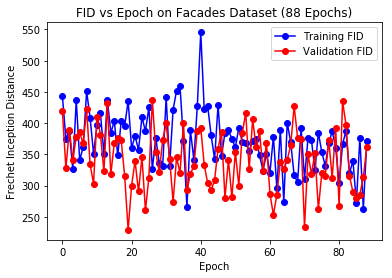

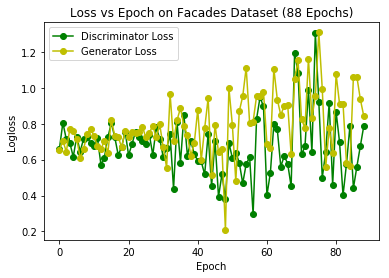

In [35]:
from matplotlib import pyplot as plt

try: assert(analysis == analysis)
except:
    try: import cPickle as pickle
    except: import pickle
    import os
    
    infile = open(os.path.join(logging_dir, "figures", model, "analysis.pkl"), "rb")
    analysis = pickle.load(infile)
    infile.close()  

x = [k for k in analysis[fid.__str__()]]
y_train = [analysis[fid.__str__()][k][0] for k in analysis[fid.__str__()]]
y_val = [analysis[fid.__str__()][k][1] for k in analysis[fid.__str__()]]
plt.plot(x, y_train, "bo-", label="Training FID")
plt.plot(x, y_val, "ro-", label="Validation FID")

plt.xlabel("Epoch")
plt.ylabel("Frechet Inception Distance")
plt.title("FID vs Epoch on %s Dataset (%d Epochs)" % (model.capitalize(), max(x)))
plt.legend()
plt.savefig(os.path.join(logging_dir, "figures", model, "fid.png"))
plt.show()

x = [k for k in analysis["disc_loss"]]
y = [analysis["disc_loss"][k] for k in analysis["disc_loss"]]
plt.plot(x, y, "go-", label="Discriminator Loss")

x = [k for k in analysis["gen_loss"]]
y = [analysis["gen_loss"][k] for k in analysis["gen_loss"]]
plt.plot(x, y, "yo-", label="Generator Loss")

plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.title("Loss vs Epoch on %s Dataset (%d Epochs)" % (model.capitalize(), max(x)))
plt.legend()
plt.savefig(os.path.join(logging_dir, "figures", model, "loss.png"))
plt.show()
#analysis["custom"]

### Analyzing Pix2Pix on Training, Validation, and Test Dataset

The code below analyzes a larger sample of training, test, and validation datasets

In [31]:
import data_utils
import general_utils
import models
import importlib
importlib.reload(data_utils)
importlib.reload(models)

#Load Data
X_full_train, X_sketch_train, X_full_val, X_sketch_val, X_full_test, X_sketch_test = data_utils.load_data(dset, image_data_format, logging_dir, include_test=True)
print("Training Dataset: %d Images" % X_full_train.shape[0])
print("Validation Dataset: %d Images" % X_full_val.shape[0])
print("Testing Dataset: %d Images" % X_full_test.shape[0])

#Load Model
img_dim = X_full_train.shape[-3:]
print("Image Dimensions %d x %d x %d" % img_dim)
nb_patch, img_dim_disc = data_utils.get_nb_patch(img_dim, d_params["patch_size"], image_data_format)
generator_model = models.load("generator_unet_%s" % d_params["generator"],
                                      img_dim,
                                      nb_patch,
                                      d_params["bn_mode"],
                                      d_params["use_mbd"],
                                      d_params["batch_size"],
                                      d_params["do_plot"],
                                      d_params["load_model"],
                                      d_params["logging_dir"],
                                      d_params["load_epoch"])

Training Dataset: 400 Images
Validation Dataset: 100 Images
Testing Dataset: 106 Images
Image Dimensions 256 x 256 x 3


In [34]:
sample = 30

X_full_batch, X_sketch_batch = data_utils.gen_batch_random(X_full_train, X_sketch_train, sample)
X_full_batch, X_sketch_batch, X_gen_batch = data_utils.get_generated_batch(X_full_batch, X_sketch_batch, generator_model)
res = analyze.analyze(X_full_batch, X_gen_batch)
print(analyze.__str__(), "On Training Dataset:", res)

X_full_batch, X_sketch_batch = data_utils.gen_batch_random(X_full_val, X_sketch_val, sample)
X_full_batch, X_sketch_batch, X_gen_batch = data_utils.get_generated_batch(X_full_batch, X_sketch_batch, generator_model)
res = analyze.analyze(X_full_batch, X_gen_batch)
print(analyze.__str__(), "On Validaiton Dataset:", res)

X_full_batch, X_sketch_batch = data_utils.gen_batch_random(X_full_test, X_sketch_test, sample)
X_full_batch, X_sketch_batch, X_gen_batch = data_utils.get_generated_batch(X_full_batch, X_sketch_batch, generator_model)
res = analyze.analyze(X_full_batch, X_gen_batch)
print(analyze.__str__(), "On Testing Dataset:", res)

FID On Training Dataset: 264.10633941953307
FID On Validaiton Dataset: 253.21715097221926
FID On Testing Dataset: 279.234517386994
